In [2]:
import networkx as nx
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

import os

sys.path.insert(0, "..")

from wikidata.wikidata_subgraphs_retriever import SubgraphsRetriever
from wikidata.wikidata_shortest_path import WikidataShortestPathCache
from wikidata.wikidata_entity_to_label import WikidataEntityToLabel

In [3]:
with open("../subgraphs_dataset/dataset_v0/meta.json", "r") as f:
    df = pd.DataFrame(json.load(f))

graphs = []
metas = []
graphs_path = Path("../subgraphs_dataset/dataset_v0/").glob("id_*")
for graph_path in graphs_path:
    with open(graph_path / "graph.json", "r") as f:
        data = json.load(f)
        graph = nx.node_link_graph(data)
        graphs.append(graph)
    with open(graph_path / "meta.json", "r") as f:
        metas.append(json.load(f))

df = pd.DataFrame(metas)
df["graph"] = graphs

In [4]:
df = df[df["candidate_id"] != ""]
df.index.size

728

In [5]:
df.head()

,original_question,ner_question,entity_texts,entity_ids,entity_scores,candidate_text,candidate_id,original_entities,correct_answer_id,correct_answer_entity,pathes,graph
1,Which film was directed by ian iqbal rashid\n,Which Film Was Directed By [START] Ian Iqbal R...,"[Ian Iqbal Rashid, List of The Apprentice cand...","[Q15461094, Q6599452]","[-0.07651346921920776, -3.091360569000244]",Touch of Pink,Q2628332,"[{'id': 'Q15461094', 'texts': ['Ian Iqbal Rash...",Q2628332,Touch of Pink,"[[Q2628332, Q15461094], [Q6599452, Q2628332]]","(Q2628332, Q15461094, Q6599452)"
2,Which film was directed by ian iqbal rashid\n,Which Film Was Directed By [START] Ian Iqbal R...,"[Ian Iqbal Rashid, List of The Apprentice cand...","[Q15461094, Q6599452]","[-0.07651346921920776, -3.091360569000244]",Aashiq,Q2820106,"[{'id': 'Q15461094', 'texts': ['Ian Iqbal Rash...",Q2628332,Touch of Pink,"[[Q15461094, Q2820106], [Q6599452, Q2820106]]","(Q15461094, Q6599452, Q2820106)"
3,what is 6864 starkenburg\n,What Is [START] 6864 Starkenburg\n [END],"[6864 Starkenburg, List of minor planets: 6001...","[Q715747, Q313483]","[0.7492752075195312, -0.9262775778770447]",asteroid,Q3863,"[{'id': 'Q715747', 'texts': ['6864 Starkenburg...",Q3863,asteroid,"[[Q715747, Q3863], [Q313483, Q1022867, Q3863]]","(Q1022867, Q313483, Q715747, Q3863)"
4,what war was thomas whitham in\n,What War Was [START] Thomas Whitham In\n [END],"[Thomas Whitham, Thomas Innes (historian)]","[Q7795073, Q3525233]","[-1.3053739070892334, -3.7151827812194824]",Korean War,Q8663,"[{'id': 'Q7795073', 'texts': ['Thomas Whitham ...",Q361,World War I,"[[Q7795073, Q174193, Q408, Q8663], [Q3525233, ...","(Q7795073, Q145, Q30, Q8663, Q3525233, Q174193..."
5,what style of msuic did john pizzarelli play \n,What Style Of Msuic Did [START] John Pizzarell...,"[John Pizzarelli, John Pizer]","[Q1701445, Q933327]","[0.5380557179450989, -5.224544525146484]",jazz,Q8341,"[{'id': 'Q1701445', 'texts': ['John Pizzarelli...",Q8341,jazz,"[[Q1701445, Q8341], [Q933327, Q8341]]","(Q8341, Q1701445, Q933327)"


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

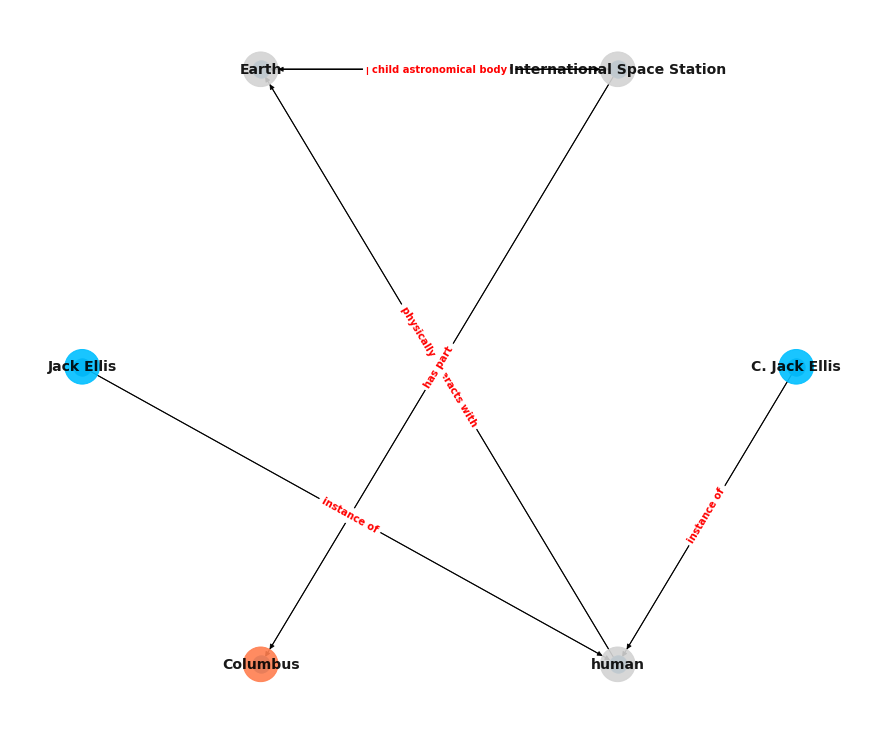

In [9]:
shortest_path = WikidataShortestPathCache()
entity2label = WikidataEntityToLabel()

SubgraphsRetriever(entity2label, shortest_path).visualize_subgraph(
    df[df["original_question"] == "what city and state was c. jack ellis born in\n"]
    .iloc[1]
    .graph
)

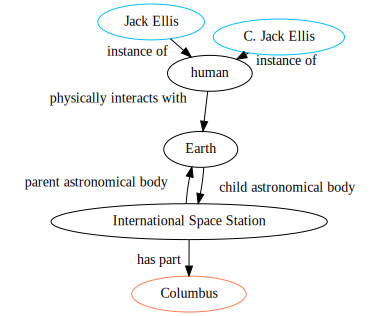

In [8]:
import graphviz
import networkx as nx
from wikidata.wikidata_entity_to_label import WikidataEntityToLabel

e2l = WikidataEntityToLabel()

g = nx.nx_agraph.to_agraph(
    df[df["original_question"] == "what city and state was c. jack ellis born in\n"]
    .iloc[1]
    .graph
)

for node in g.iternodes():
    if node.attr["node_type"] == "Answer candidate entity":
        node.attr["color"] = "#FF7F50"
    elif node.attr["node_type"] == "Question entity":
        node.attr["color"] = "#00BFFF"
    node.attr["label"] = e2l.get_label(node)

for edge in g.iteredges():
    edge.attr["label"] = e2l.get_label(edge.attr["label"])

g.layout()
g.draw("p.png", prog="dot")
g

In [10]:
def generate_string_for_classify(
    graph,
    source,
    sep_token="[SEP]",
    not_connected_tokens_sep="[SEP][SEP]",
    unk_token="[UNK]",
):
    graph = graph.to_undirected()
    all_nodes = set(graph.nodes)

    way = list(nx.dfs_edges(graph, source=source))
    string_for_classify = ""
    if len(way) > 0:
        string_for_classify += str(entity2label.get_label(source)) + sep_token
        all_nodes.remove(source)

        for edge in way:
            prop = graph.edges[edge]["label"]
            edge_label = str(entity2label.get_label(prop))
            string_for_classify += edge_label + sep_token
            string_for_classify += str(entity2label.get_label(edge[1])) + sep_token
            all_nodes.remove(edge[1])

    if len(all_nodes) > 0:
        string_for_classify += not_connected_tokens_sep
        for not_connected_node in list(all_nodes):
            string_for_classify += (
                str(entity2label.get_label(not_connected_node))
                + not_connected_tokens_sep
            )

    return string_for_classify.replace("None", unk_token)

In [11]:
all_questions = df["original_question"].unique()

train_questions = all_questions[len(all_questions) // 3 :]
test_questions = all_questions[: len(all_questions) // 3]

In [12]:
from collections import defaultdict


train_dataset = defaultdict(list)
test_dataset = defaultdict(list)

for idx in range(df.index.size):
    label = df.iloc[idx]["correct_answer_id"] == df.iloc[idx]["candidate_id"]
    string_example = generate_string_for_classify(
        df.iloc[idx]["graph"], df.iloc[idx]["candidate_id"]
    )
    if df.iloc[idx]["original_question"] in train_questions:
        train_dataset["label"].append(label)
        train_dataset["string_example"].append(string_example)
    else:
        test_dataset["label"].append(label)
        test_dataset["string_example"].append(string_example)

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-31 10:09:16.835246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 10:09:17.041254: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 10:09:17.927570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file

In [14]:
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)

train_dataset, test_dataset

(Dataset({
     features: ['label', 'string_example'],
     num_rows: 467
 }),
 Dataset({
     features: ['label', 'string_example'],
     num_rows: 261
 }))

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-large-cased")
model = BertForSequenceClassification.from_pretrained("bert-large-cased", num_labels=2)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [13]:
def tokenize_fn(examples):
    return tokenizer(examples["string_example"], padding="max_length", truncation=True)


train_dataset = train_dataset.map(tokenize_fn, batched=True).shuffle()
test_dataset = test_dataset.map(tokenize_fn, batched=True)

100%|██████████| 1/1 [00:00<00:00,  2.96ba/s]


In [14]:
import numpy as np
import evaluate

metric = evaluate.combine(["f1", "precision", "recall", "accuracy"])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [15]:
from torch import nn
from transformers import Trainer


target = np.array(train_dataset["label"]).astype(int)

class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1.0 / class_sample_count


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight).float()).to(
            logits.device
        )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [16]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_first_step=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    # load_best_model_at_end=True,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: string_example. If string_example are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 467
  Num Epochs = 15
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 435


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
0,0.517900,0.721361,0.000000,0.000000,0.000000,0.819923
1,0.457800,0.717110,0.000000,0.000000,0.000000,0.819923
2,0.429700,0.771010,0.076923,0.400000,0.042553,0.816092
3,0.354500,0.695894,0.480000,0.642857,0.382979,0.850575
4,0.305200,0.665511,0.554217,0.638889,0.489362,0.858238
5,0.257100,0.834336,0.547945,0.769231,0.425532,0.873563
6,0.227500,0.740314,0.554217,0.638889,0.489362,0.858238
7,0.205400,0.733739,0.488372,0.538462,0.446809,0.831418
8,0.168700,1.089283,0.514286,0.782609,0.382979,0.869732
9,0.131500,0.877742,0.558140,0.615385,0.510638,0.854406


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: string_example. If string_example are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 261
  Batch size = 8
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: string_example. If string_example are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 261
  Batch size = 8
/usr/local/lib/p

TrainOutput(global_step=435, training_loss=0.2361026435062803, metrics={'train_runtime': 1170.9776, 'train_samples_per_second': 5.982, 'train_steps_per_second': 0.371, 'total_flos': 6525383406022656.0, 'train_loss': 0.2361026435062803, 'epoch': 14.99})

# CatBoost of graphs

In [18]:
train_df = df[df["original_question"].apply(lambda q: q in train_questions)]
test_df = df[df["original_question"].apply(lambda q: q in test_questions)]

train_df.index.size, test_df.index.size

(467, 261)

In [19]:
train_df[["entity_ids", "candidate_id"]].head()

,entity_ids,candidate_id
77,"[Q2747238, Q5042155]",Q1050571
78,[Q312480],Q924136
79,"[Q14159489, Q10729673]",Q1860
80,"[Q4659687, Q520787]",Q21079067
81,"[Q226730, Q17093751]",Q3837701


In [31]:
from reranking import feature_extraction


def graph_to_features(graph, pathes, candidate_entity):
    graph_undir = graph.to_undirected()
    pathes_lens = [len(p) for p in pathes]

    try:
        ev_cent = feature_extraction.eigenvector_centrality(graph).get(
            candidate_entity, 0
        )
    except:
        ev_cent = 0

    return [
        min(pathes_lens),
        max(pathes_lens),
        feature_extraction.number_of_triangles(graph, True),
        *feature_extraction.nodes_and_edges(graph),
        feature_extraction.katz_centrality(graph).get(candidate_entity, 0),
        ev_cent,
        feature_extraction.large_clique_size(graph_undir),
        # feature_extraction.diameter(graph_undir),
        feature_extraction.pagerank(graph_undir).get(candidate_entity, 0),
    ]


graph_to_features(
    df.iloc[2].graph,
    df.iloc[2].pathes,
    df.iloc[2].candidate_id,
)

/workspace/kbqa/experiments/../reranking/feature_extraction.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(
/workspace/kbqa/experiments/../reranking/feature_extraction.py:51: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(


[2, 3, 8, 4, 5, 0.5472704147154813, 0.7071067811865476, 2, 0.32456160227748454]

In [21]:
train_X = np.array(
    train_df.apply(
        lambda row: graph_to_features(row.graph, row.pathes, row.candidate_id), axis=1
    ).values.tolist()
)
test_X = np.array(
    test_df.apply(
        lambda row: graph_to_features(row.graph, row.pathes, row.candidate_id), axis=1
    ).values.tolist()
)

train_y = (train_df["candidate_id"] == train_df["correct_answer_id"]).values.astype(int)
test_y = (test_df["candidate_id"] == test_df["correct_answer_id"]).values.astype(int)

/workspace/kbqa/experiments/../reranking/feature_extraction.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(
/workspace/kbqa/experiments/../reranking/feature_extraction.py:51: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(


In [22]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()
clf.fit(
    train_X,
    train_y,
)

Learning rate set to 0.007443
0:	learn: 0.6865837	total: 59ms	remaining: 58.9s
1:	learn: 0.6797073	total: 67.9ms	remaining: 33.9s
2:	learn: 0.6735624	total: 76.4ms	remaining: 25.4s
3:	learn: 0.6666344	total: 83.4ms	remaining: 20.8s
4:	learn: 0.6616235	total: 87.6ms	remaining: 17.4s
5:	learn: 0.6557839	total: 98.4ms	remaining: 16.3s
6:	learn: 0.6495101	total: 107ms	remaining: 15.2s
7:	learn: 0.6436290	total: 113ms	remaining: 14s
8:	learn: 0.6370514	total: 118ms	remaining: 13s
9:	learn: 0.6342871	total: 122ms	remaining: 12.1s
10:	learn: 0.6283959	total: 127ms	remaining: 11.4s
11:	learn: 0.6220922	total: 130ms	remaining: 10.7s
12:	learn: 0.6165226	total: 135ms	remaining: 10.2s
13:	learn: 0.6116174	total: 140ms	remaining: 9.84s
14:	learn: 0.6054203	total: 145ms	remaining: 9.5s
15:	learn: 0.6010201	total: 150ms	remaining: 9.21s
16:	learn: 0.5958096	total: 153ms	remaining: 8.84s
17:	learn: 0.5906704	total: 157ms	remaining: 8.57s
18:	learn: 0.5855113	total: 162ms	remaining: 8.37s
19:	learn: 0

In [23]:
compute_metrics((clf.predict_proba(test_X), test_y))

{'f1': 0.575,
 'precision': 0.696969696969697,
 'recall': 0.48936170212765956,
 'accuracy': 0.8697318007662835}

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(train_X, train_y)

compute_metrics((clf.predict_proba(test_X), test_y))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'f1': 0.3050847457627119,
 'precision': 0.75,
 'recall': 0.19148936170212766,
 'accuracy': 0.842911877394636}